# Yelp dataset: CAVI vs noise
    
Experiments that explore the performance of CAVI at different levels of noise.

In [1]:
import collabclass
import json
import matplotlib.pyplot as plt
import numpy as np

## Loading & preparing the data

In [2]:
classes = (
    "AZ",
    "NV",
    "ON",
    "OH",
    "NC",
    "PA",
    "QC",
    "AB",
    "WI",
    "IL",
)

cls2idx = {cls: idx for idx, cls in enumerate(classes)}
k = len(cls2idx)

In [3]:
%%time
label = dict()
with open("../_data/yelp/yelp_academic_dataset_business.json") as f:
    for line in f:
        biz = json.loads(line)
        if biz["state"] in classes:
            label[biz["business_id"]] = biz["state"]

CPU times: user 2.19 s, sys: 89.5 ms, total: 2.28 s
Wall time: 2.3 s


In [4]:
%%time

user_cnt = 0
item_cnt = 0
user2idx = dict()
item2idx = dict()

edges = list()

with open("../_data/yelp/yelp_academic_dataset_review.json") as f:
    for line in f:
        x = json.loads(line)
        uid = x["user_id"]
        bid = x["business_id"]
        if bid not in label:
            # We don't have the business -> skip.
            continue
        if bid not in item2idx:
            item2idx[bid] = item_cnt
            item_cnt += 1
        if uid not in user2idx:
            user2idx[uid] = user_cnt
            user_cnt += 1
        edges.append((user2idx[uid], item2idx[bid]))

m = user_cnt
n = item_cnt
    
graph = collabclass.graph_from_edges(m, n, edges)

CPU times: user 1min 20s, sys: 3.38 s, total: 1min 23s
Wall time: 1min 24s


In [5]:
print("Number of users: {:,}".format(m))
print("Number of items:   {:,}".format(n))
print("Number of edges: {:,}".format(len(graph.user_edges)))

Number of users: 1,962,440
Number of items:   207,974
Number of edges: 7,990,277


In [6]:
idx2item = {v: k for k, v in item2idx.items()}
vs = list()
for j in range(n):
    cat = label[idx2item[j]]
    vs.append(cls2idx[cat])
vs = np.array(vs)

## Plot results

In [7]:
%%time
deltas = np.linspace(0.05, 0.85, num=9)
alpha = np.ones((m, k))

np.random.seed(0)
deltas2 = np.hstack(([0], deltas, [0.9]))
res2a = np.zeros(len(deltas2))
res2b = np.zeros(len(deltas2))
inf_deltas = np.array([1e-7, 0.6, 0.8, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.895, 0.895])
for i, delta in enumerate(deltas2):
    print(".", end="", flush=True)
    vs_hat = collabclass.symmetric_channel(vs, k, delta=delta)
    beta = collabclass.init_beta(k, vs_hat, delta=inf_deltas[i])
    apost, bpost = collabclass.cavi(graph, alpha, beta, 3)
    rankings = np.argsort(bpost, axis=1)[:,::-1]
    top1 = (rankings[:,0] != vs)
    ps = np.percentile(graph.item_idx[:,1], (50, 90, 98))
    mask = (graph.item_idx[:,1] >= ps[1])
    res2a[i] = np.count_nonzero(top1) / len(vs)
    res2b[i] = np.count_nonzero(top1[mask]) / np.count_nonzero(mask)
print()

...........
CPU times: user 1min 48s, sys: 3.18 s, total: 1min 51s
Wall time: 1min 52s


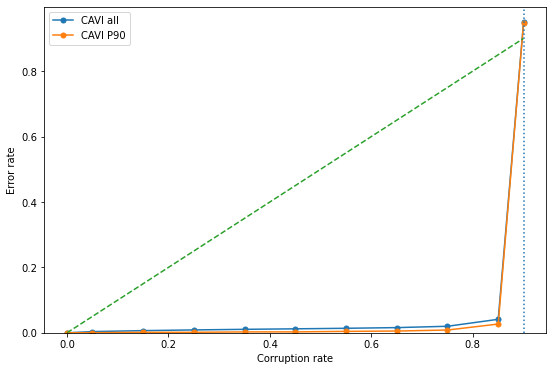

In [8]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(deltas2, res2a, marker="o", ms=5, label="CAVI all")
ax.plot(deltas2, res2b, marker="o", ms=5, label="CAVI P90")
ax.plot(deltas2, deltas2, ls="--")
ax.axvline(0.9, ls=":")
ax.set_ylim(bottom=0.0)
ax.set_xlabel("Corruption rate")
ax.set_ylabel("Error rate")
ax.legend()